<a href="https://colab.research.google.com/github/MarehWilliams01/jubilant-fishstick/blob/main/lgbtq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install emoji

In [89]:
# Importing the neccessary libraries
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import emoji
import requests
from bs4 import BeautifulSoup
import spacy

plt.style.use('fivethirtyeight')

In [ ]:
# Assigning the LGBTQ dataset to a data object
data = pd.read_csv('/content/drive/MyDrive/LGBTQ-Reduced.csv')
data.head()

# Storing the tweets in a dataframe
df_lgbtq = pd.DataFrame(data['tweet'])
print(df_lgbtq.head())

In [ ]:
# Send a GET request to the website
url = "https://messente.com/blog/text-abbreviations"
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Find the second and third b tags and extract the data
b_tags = soup.find_all("b")
second_b_tag = b_tags[1]
third_b_tag = b_tags[2]

# Find all paragraphs inside the second and third b tags, excluding the first paragraph
second_paragraphs = second_b_tag("p")[1:]
third_paragraphs = third_b_tag("p")[1:]

# Extract the slang words and descriptions
slang_list = []
description_list = []
count = 0

for paragraph in second_paragraphs + third_paragraphs:
  if count <= 99:
    split_text = paragraph.text.strip().split(" – ", 1)
    slang = split_text[0].split(". ", 1)[-1].lower()
    description = split_text[1] if len(split_text) > 1 else ""
    slang_list.append(slang)
    description_list.append(description)
    count += 1

  else:
    break

# Create a DataFrame from the extracted data
df_slangs = pd.DataFrame({
    "slang": slang_list,
    "description": description_list
})

# Print the DataFrame
print(df_slangs)

In [ ]:
# Preprocessing the data

# Developing a function to do clean the data
def clean_tweet(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # removes mentions
  text = re.sub(r'#', '', text) # removes hashtags
  text = re.sub(r'RT[\s]+', '', text) # removes retweets
  text = re.sub(r'https?:\/\/\S+', '', text) # removes hyperlinks
  text = re.sub(r'\.{2,}', '.', text) # removes repeated fullstops
  text = re.sub(r'!{2,}', '!', text) # removes repeated exclammation marks
  text = re.sub(r'\?{2,}', '?', text) # removes repeated question marks
  text = re.sub(r'\s+', ' ', text) # removes extra space around text
  text = emoji.demojize(text, delimiters=("", "")) # replacing the emojis with respective labels

  words = text.split() # splits text into each word
  normalized_words = [df_slangs.loc[df_slangs['slang'] == word, "description"].values[0]
    if word in df_slangs['slang'].values else word for word in words] # removes slangs
  text = " ".join(normalized_words)

  return text.lower()

# Cleaning the tweet
df_lgbtq['tweet'] = df_lgbtq['tweet'].apply(clean_tweet)

# Showing the prepocessed data
df_lgbtq.head()

In [ ]:
# Lemmatization

nlp = spacy.load("en_core_web_sm")

# Define a function to lemmatize each word in a text
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

# Apply lemmatization to the 'tweet' column
df_lgbtq['tweet'] = df_lgbtq['tweet'].apply(lemmatize_text)

print(df_lgbtq['tweet'])


In [ ]:
# Getting the subjectivity and polarity of tweets

# creating a function to get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# creating a function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# adding subjectivity and polarity of tweets as columns to dataset
df_lgbtq['Subjectivity'] = df_lgbtq['tweet'].apply(getSubjectivity)
df_lgbtq['Polarity'] = df_lgbtq['tweet'].apply(getPolarity)

# showing the dataset
df_lgbtq

In [ ]:
# Plotting the Word Cloud
words = ' '.join([tweets for tweets in df_lgbtq['tweet']])
wordcloud = WordCloud(width=1000, height=300, random_state=21, background_color='white', max_font_size=200 ).generate(words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Function to find negative, neutral and positive tweets
def analyse(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

df_lgbtq['Analysis'] = df_lgbtq['Polarity'].apply(analyse)

df_lgbtq

In [ ]:
# Finding all positive tweets
q=1
lgbtq_sorted = df_lgbtq.sort_values(by=['Polarity'])
for l in range(0, lgbtq_sorted.shape[0]):
  if(lgbtq_sorted['Analysis'][l] == 'Positive'):
    print(str(q) + ') ' + lgbtq_sorted['tweet'][l])
    print()
    q = q+1

In [ ]:
# Finding all negative tweets
q=1
lgbtq_sorted = df_lgbtq.sort_values(by=['Polarity'], ascending=False)
for l in range(0, lgbtq_sorted.shape[0]):
  if(lgbtq_sorted['Analysis'][l] == 'Negative'):
    print(str(q) + ') ' + lgbtq_sorted['tweet'][l])
    print()
    q = q+1

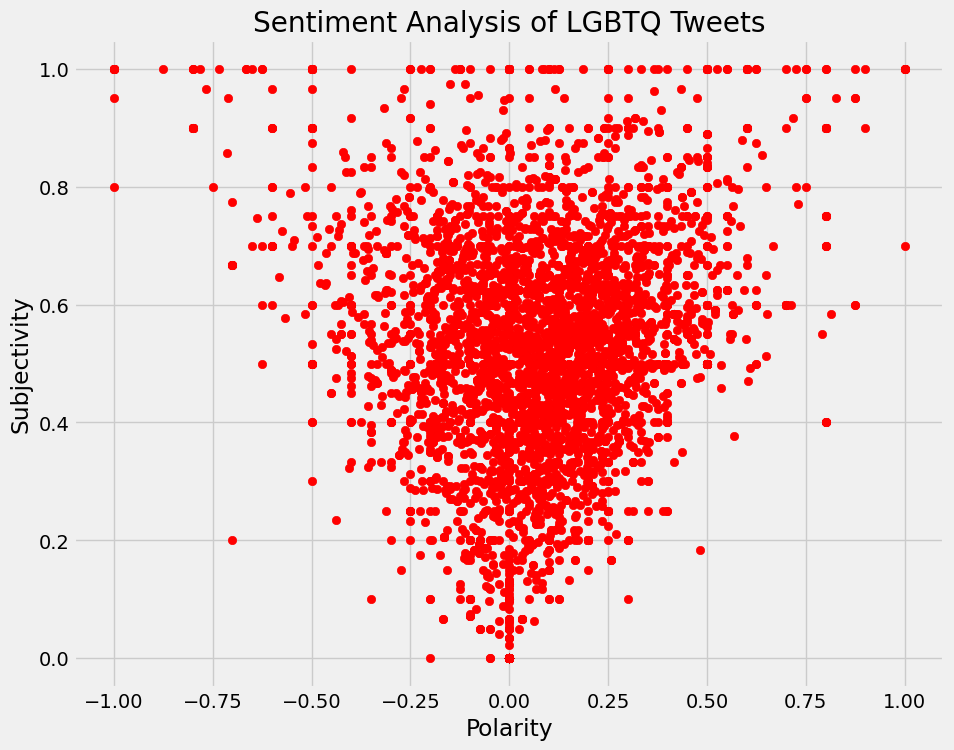

In [105]:
# Plotting a graph of polarity and subjectivity
plt.figure(figsize=(10,8))
for i in range(0, df_lgbtq.shape[0]):
  plt.scatter(df_lgbtq['Polarity'][i], df_lgbtq['Subjectivity'][i], color='Red')

plt.title('Sentiment Analysis of LGBTQ Tweets')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [102]:
# Getting percentage of positive and negative tweets

# positive tweets
p_tweets = df_lgbtq[df_lgbtq.Analysis == 'Positive']
p_tweets = p_tweets['tweet']

round( (p_tweets.shape[0] / df_lgbtq.shape[0]) * 100, 1)

52.4

In [103]:
# negative tweets
n_tweets = df_lgbtq[df_lgbtq.Analysis == 'Negative']
n_tweets = n_tweets['tweet']

round( (n_tweets.shape[0] / df_lgbtq.shape[0]) * 100, 1)

27.6

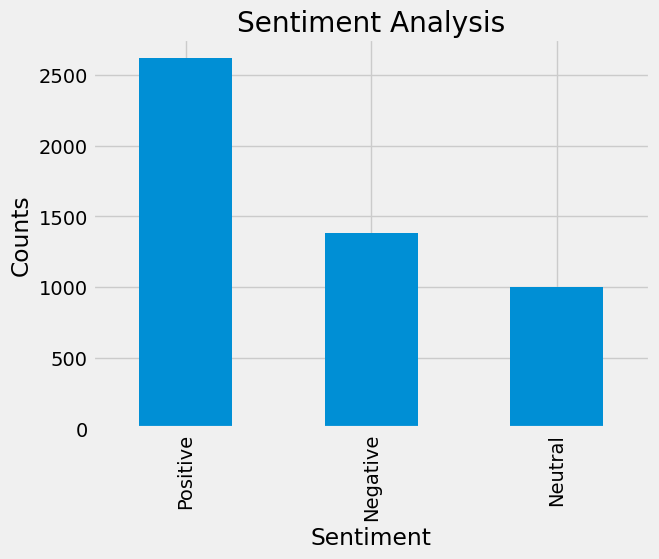

In [104]:
# Value Counts

df_lgbtq['Analysis'].value_counts()

# plot and visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_lgbtq['Analysis'].value_counts().plot(kind='bar')
plt.show()